In [188]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [240]:
#full lightcast data pull
file_path = "C:/Users/ConnorChristensen/OneDrive - Wyoming Business Council/Documents/Analysis/lc_data24.csv"  
df = pd.read_csv(file_path)

#drop unnecessary columns
df = df.drop(['Area Bucket', 'Industry Bucket'], axis=1)

#drop non-county data
df = df[~df['Area Name'].str.contains("county not reported", case=False, na=False)]

#get that crosswalk in there
file_path_cw = "C:/Users/ConnorChristensen/OneDrive - Wyoming Business Council/Documents/GitHub/Economic-Complexity/county20.csv"  
cw = pd.read_csv(file_path_cw)

#merge it up
df = df.merge(cw, left_on="Area", right_on="GEOID", how="left")

#drop the GEOID, it's already represented with "Area"
df = df.drop(['GEOID'], axis=1)

In [190]:
print(df.head(25))

           Area Name                                      Industry Name  \
0   Adair County, IA                                    Crop Production   
1   Adair County, IA                                  Animal Production   
2   Adair County, IA                            Timber Tract Operations   
3   Adair County, IA  Forest Nurseries and Gathering of Forest Products   
4   Adair County, IA                                            Logging   
5   Adair County, IA                                    Finfish Fishing   
6   Adair County, IA                                  Shellfish Fishing   
7   Adair County, IA                               Other Marine Fishing   
8   Adair County, IA                               Hunting and Trapping   
9   Adair County, IA                                     Cotton Ginning   
10  Adair County, IA        Soil Preparation, Planting, and Cultivating   
11  Adair County, IA              Crop Harvesting, Primarily by Machine   
12  Adair County, IA  Pos

In [241]:
'''
Jobs_county = number of jobs in the county in that industry
Jobs_CZ = number of jobs in that cz in that industry
Total_Jobs_CZ = total number of jobs in each cz
'''
# Ensure 'Jobs_county' column is numeric. Changed the name for additional clarity
df['Jobs_county'] = pd.to_numeric(df['Jobs'], errors='coerce') #transformed from Jobs

# Combine 'Jobs_county' for all counties in each CZ
df['Jobs_CZ'] = df.groupby(['CZ20', 'Industry'])['Jobs'].transform('sum') #transformed from Total_Employment

# Compute total employment in each commuting zone across all industries
df['Total_Jobs_CZ'] = df.groupby('CZ20')['Jobs'].transform('sum') #transformed from Total_CZ_Employment

# Calculate industry's share of total employment in the commuting zone
df['Employment_Share'] = df['Jobs_CZ'] / df['Total_Jobs_CZ']

# Compute log transformations
df['Log_Total_Jobs_CZ'] = np.log(df['Total_Jobs_CZ'])
df['Log_Total_Jobs_CZ_Squared'] = df['Log_Total_Jobs_CZ'] ** 2

# Drop any remaining duplicates (just to be safe)
df_cz = df.drop_duplicates(subset=['CZ20', 'Industry'])

#collapsed data
#df = df[['CZ20', 'Area', 'Area Name', 'Industry', 'Industry Name', 'Jobs', 'Total_CZ_Employment', 'Employment_Share']].drop_duplicates()

'''
# Ensure 'Jobs_county' column is numeric
df['Jobs_county'] = pd.to_numeric(df['Jobs'], errors='coerce')  

# Aggregate jobs at the CZ level (sum across counties)
df_cz = df.groupby(['CZ20', 'Industry', 'Industry Name'], as_index=False).agg({
    'Jobs_county': 'sum',  # Total jobs in CZ for the industry
    'Total_Jobs_CZ': 'first',  # Total jobs in CZ (same for all counties)
})

# Recalculate employment share
df_cz['Employment_Share'] = df_cz['Jobs_county'] / df_cz['Total_Jobs_CZ']

# Compute log transformations
df_cz['Log_Total_Jobs_CZ'] = np.log(df_cz['Total_Jobs_CZ'])
df_cz['Log_Total_Jobs_CZ_Squared'] = df_cz['Log_Total_Jobs_CZ'] ** 2

# Drop any remaining duplicates (just to be safe)
df_cz = df_cz.drop_duplicates(subset=['CZ20', 'Industry'])

print(df_cz.head())  # Check that we now have one row per industry per CZ
'''

"\n# Ensure 'Jobs_county' column is numeric\ndf['Jobs_county'] = pd.to_numeric(df['Jobs'], errors='coerce')  \n\n# Aggregate jobs at the CZ level (sum across counties)\ndf_cz = df.groupby(['CZ20', 'Industry', 'Industry Name'], as_index=False).agg({\n    'Jobs_county': 'sum',  # Total jobs in CZ for the industry\n    'Total_Jobs_CZ': 'first',  # Total jobs in CZ (same for all counties)\n})\n\n# Recalculate employment share\ndf_cz['Employment_Share'] = df_cz['Jobs_county'] / df_cz['Total_Jobs_CZ']\n\n# Compute log transformations\ndf_cz['Log_Total_Jobs_CZ'] = np.log(df_cz['Total_Jobs_CZ'])\ndf_cz['Log_Total_Jobs_CZ_Squared'] = df_cz['Log_Total_Jobs_CZ'] ** 2\n\n# Drop any remaining duplicates (just to be safe)\ndf_cz = df_cz.drop_duplicates(subset=['CZ20', 'Industry'])\n\nprint(df_cz.head())  # Check that we now have one row per industry per CZ\n"

In [192]:
print(df_cz.head(25))

           Area Name                                      Industry Name  \
0   Adair County, IA                                    Crop Production   
1   Adair County, IA                                  Animal Production   
2   Adair County, IA                            Timber Tract Operations   
3   Adair County, IA  Forest Nurseries and Gathering of Forest Products   
4   Adair County, IA                                            Logging   
5   Adair County, IA                                    Finfish Fishing   
6   Adair County, IA                                  Shellfish Fishing   
7   Adair County, IA                               Other Marine Fishing   
8   Adair County, IA                               Hunting and Trapping   
9   Adair County, IA                                     Cotton Ginning   
10  Adair County, IA        Soil Preparation, Planting, and Cultivating   
11  Adair County, IA              Crop Harvesting, Primarily by Machine   
12  Adair County, IA  Pos

In [193]:
def run_ppml_tj(df, naics_code):
    """
    Runs a Pseudo-Poisson Maximum Likelihood (PPML) regression for a specific industry
    identified by its 6-digit NAICS code across all commuting zones (CZ20) 
    and generates a single plot.
    
    Parameters:
    df (DataFrame): The dataset containing employment data.
    naics_code (int or str): The 6-digit NAICS code of the industry.
    """

    # Convert NAICS code to string (in case it's stored as int)
    naics_code = str(naics_code)

    # Retrieve the industry name corresponding to the NAICS code
    if naics_code not in df['Industry'].astype(str).values:
        print(f"No data available for NAICS code {naics_code}.")
        return

    industry_name = df[df['Industry'].astype(str) == naics_code]['Industry Name'].iloc[0]

    # Filter the dataset for the given NAICS industry
    df_industry = df[df['Industry'].astype(str) == naics_code].copy()

    # Drop missing or infinite values
    df_industry = df_industry.replace([np.inf, -np.inf], np.nan).dropna()

    # Define the regression formula
    formula = "Jobs_CZ ~ Log_Total_Jobs_CZ + Log_Total_Jobs_CZ_Squared"

    # Run PPML regression across all zones
    model = smf.glm(formula=formula, data=df_industry, family=sm.families.Poisson()).fit()

    # Print regression summary
    print(model.summary())

    # Plot Jobs vs Log Total Employment for all zones
    plt.figure(figsize=(8, 5))
    plt.scatter(df_industry['Log_Total_Jobs_CZ'], np.log1p(df_industry['Jobs_CZ']), alpha=0.5, label='Data')

    # Generate predicted values
    df_industry['Predicted_Jobs'] = model.predict(df_industry)

    # Sort values for smooth line
    sorted_df = df_industry.sort_values('Log_Total_Jobs_CZ')

    # Plot regression line
    plt.plot(sorted_df['Log_Total_Jobs_CZ'], np.log(sorted_df['Predicted_Jobs']), color='red', label='PPML Fit')

    # Labels and title
    plt.xlabel("Log Number of Total Jobs in Commuting Zone")
    plt.ylabel(f"Log Number of Jobs in {industry_name} in Commuting Zone")
    plt.title(f"PPML Regression for {industry_name} (NAICS {naics_code})")
    plt.legend()
    plt.grid(True)
    
    # Prevent y-axis from dropping below zero
    plt.ylim(bottom=0)
    
    # Show plot
    plt.show()


                 Generalized Linear Model Regression Results                  
Dep. Variable:                Jobs_CZ   No. Observations:                  583
Model:                            GLM   Df Residuals:                      580
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.7614e+05
Date:                Wed, 12 Mar 2025   Deviance:                   7.4818e+05
Time:                        17:34:02   Pearson chi2:                 1.63e+06
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

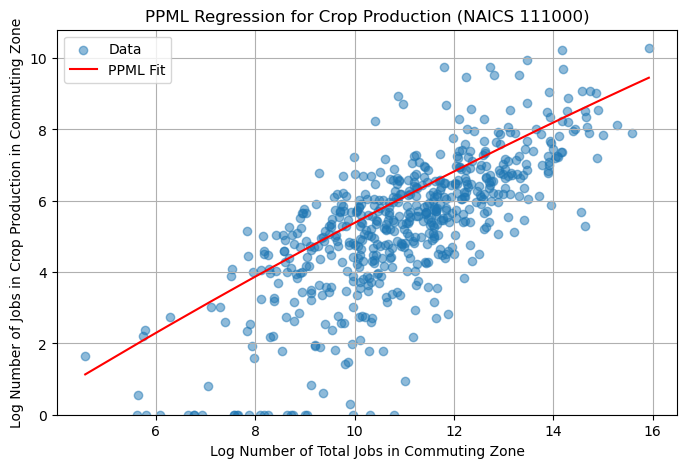

In [244]:
run_ppml_tj(df_cz, naics_code=111000)

In [246]:
def run_ppml_sj(df, naics_code):
    """
    Runs a Pseudo-Poisson Maximum Likelihood (PPML) regression for a specific industry
    identified by its 6-digit NAICS code across all commuting zones (CZ20) 
    and generates a single plot.
    
    Parameters:
    df (DataFrame): The dataset containing employment data.
    naics_code (int or str): The 6-digit NAICS code of the industry.
    """

    # Convert NAICS code to string (in case it's stored as int)
    naics_code = str(naics_code)

    # Retrieve the industry name corresponding to the NAICS code
    if naics_code not in df['Industry'].astype(str).values:
        print(f"No data available for NAICS code {naics_code}.")
        return

    industry_name = df[df['Industry'].astype(str) == naics_code]['Industry Name'].iloc[0]

    # Filter the dataset for the given NAICS industry
    df_industry = df[df['Industry'].astype(str) == naics_code].copy()

    # Drop missing or infinite values
    df_industry = df_industry.replace([np.inf, -np.inf], np.nan).dropna()

    # Define the regression formula
    formula = "Employment_Share ~ Log_Total_Jobs_CZ + Log_Total_Jobs_CZ_Squared"

    # Run PPML regression across all zones
    model = smf.glm(formula=formula, data=df_industry, family=sm.families.Poisson()).fit()

    # Print regression summary
    print(model.summary())

    # Plot Jobs vs Log Total Employment for all zones
    plt.figure(figsize=(8, 5))
    plt.scatter(df_industry['Log_Total_Jobs_CZ'],(df_industry['Employment_Share']), alpha=0.5, label='Data')

    # Generate predicted values
    df_industry['Predicted_Share'] = model.predict(df_industry)

    # Sort values for smooth line
    sorted_df = df_industry.sort_values('Log_Total_Jobs_CZ')

    # Plot regression line
    plt.plot(sorted_df['Log_Total_Jobs_CZ'], (sorted_df['Predicted_Share']), color='red', label='PPML Fit')

    # Labels and title
    plt.xlabel("Log Number of Total Jobs in Commuting Zone")
    plt.ylabel(f"Share of Jobs in {industry_name} in Commuting Zone")
    plt.title(f"PPML Regression for {industry_name} (NAICS {naics_code})")
    plt.legend()
    plt.grid(True)
    
    # Prevent y-axis from dropping below zero
    #plt.ylim(bottom=0)
    
    # Show plot
    plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:       Employment_Share   No. Observations:                  583
Model:                            GLM   Df Residuals:                      580
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:               -0.56433
Date:                Wed, 12 Mar 2025   Deviance:                      0.34119
Time:                        17:34:20   Pearson chi2:                     1.87
No. Iterations:                     6   Pseudo R-squ. (CS):          5.449e-05
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

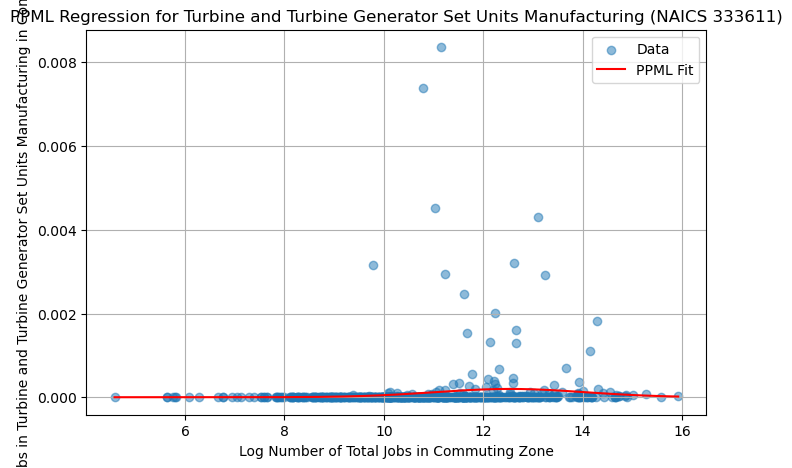

---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[242], line 75, in display_clicked_data(
    clickData={'points': [{'color': 1.1310374450200482, 'currentPath': '/', 'curveNumber': 0, 'customdata': [1.1310374450200482], 'entry': 'Turbine and Turbine Generator Set Units Manufacturing', 'id': 'Turbine and Turbine Generator Set Units Manufacturing', 'label': 'Turbine and Turbine Generator Set Units Manufacturing', 'marker.pattern.fgcolor': 1.1310374450200482, 'parent': '', 'percentEntry': 1, ...}]},
    selected_cz=84
)
     73     industry_name = clickData["points"][0]["label"]
     74     selected_row = df_around_wy[df_around_wy["Industry Name"] == industry_name].iloc[0]
---> 75     fig = run_ppml_sj(df_around_wy, selected_row["Industry"], selected_cz)
        selected_row = Area Name                                                    Larimer County, CO
Industry Name            

In [247]:
run_ppml_sj(df_cz, naics_code=333611)

In [197]:
df_cz['Industry'] = df_cz['Industry'].astype(str)

C:\Users\ConnorChristensen\AppData\Local\Temp\ipykernel_28152\2919434685.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [198]:
scaling_coefficients = {}

for naics_code in df_cz['Industry'].astype(str).unique():
    df_industry = df_cz[df_cz['Industry'] == naics_code].copy()
    
    print(f"Processing Industry: {naics_code}, Observations: {len(df_industry)}")  # Debugging print

    if len(df_industry) < 10:
        continue  # Skip industries with too few data points

    formula = "Jobs_CZ ~ Log_Total_Jobs_CZ + Log_Total_Jobs_CZ_Squared"

    try:
        model = smf.glm(formula=formula, data=df_industry, family=sm.families.Poisson()).fit()
        
        # Extract coefficients
        beta_0 = model.params.get("Intercept", np.nan)  
        beta_1 = model.params.get("Log_Total_Jobs_CZ", np.nan)
        beta_2 = model.params.get("Log_Total_Jobs_CZ_Squared", np.nan)  

        # Store all coefficients
        scaling_coefficients[naics_code] = (beta_0, beta_1, beta_2)

    except Exception as e:
        print(f"Error processing NAICS {naics_code}: {e}")

# Convert to DataFrame
df_scaling = pd.DataFrame.from_dict(scaling_coefficients, orient="index", 
                                    columns=["Intercept_tj", "Beta1_tj", "Beta2_tj"])
df_scaling.reset_index(inplace=True)
df_scaling.rename(columns={"index": "Industry"}, inplace=True)

Processing Industry: 111000, Observations: 584
Processing Industry: 112000, Observations: 584
Processing Industry: 113110, Observations: 584
Processing Industry: 113210, Observations: 584
Processing Industry: 113310, Observations: 584
Processing Industry: 114111, Observations: 584
Processing Industry: 114112, Observations: 584
Processing Industry: 114119, Observations: 584
Processing Industry: 114210, Observations: 584
Processing Industry: 115111, Observations: 584
Processing Industry: 115112, Observations: 584
Processing Industry: 115113, Observations: 584
Processing Industry: 115114, Observations: 584
Processing Industry: 115115, Observations: 584
Processing Industry: 115116, Observations: 584
Processing Industry: 115210, Observations: 584
Processing Industry: 115310, Observations: 584
Processing Industry: 211120, Observations: 584
Processing Industry: 211130, Observations: 584
Processing Industry: 212114, Observations: 584
Processing Industry: 212115, Observations: 584
Processing In

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning:

invalid value encountered in divide



Processing Industry: 902612, Observations: 584
Processing Industry: 902619, Observations: 584
Processing Industry: 902622, Observations: 584
Processing Industry: 902999, Observations: 584
Processing Industry: 903611, Observations: 584
Processing Industry: 903612, Observations: 584
Processing Industry: 903619, Observations: 584
Processing Industry: 903622, Observations: 584
Processing Industry: 903999, Observations: 584
Processing Industry: 999999, Observations: 584


In [199]:
print(df_scaling.head(25))

   Industry  Intercept_tj   Beta1_tj  Beta2_tj
0    111000     -2.853885   0.909023 -0.008552
1    112000     -2.629523   1.160607 -0.034189
2    113110    -21.506141   3.489341 -0.127294
3    113210    -12.974563   1.876878 -0.056677
4    113310    -17.400035   3.446830 -0.133367
5    114111      4.861974  -1.191309  0.074910
6    114112    -15.606091   2.076479 -0.055802
7    114119    -88.597043  12.427563 -0.425779
8    114210     -1.356119  -0.009269  0.019757
9    115111    -11.445436   2.200628 -0.085963
10   115112     -5.882447   1.064486 -0.020220
11   115113    -12.096594   1.804221 -0.045352
12   115114    -22.341829   3.821455 -0.126980
13   115115    -61.919994   9.667828 -0.336470
14   115116    -12.180470   1.854485 -0.044814
15   115210    -11.214292   1.773329 -0.042184
16   115310    -15.476143   2.728468 -0.092939
17   211120      5.728267  -0.857824  0.064110
18   211130      2.891268  -0.469527  0.046319
19   212114    -25.270253   5.217375 -0.233011
20   212115  

In [200]:
df_cz = df_cz.merge(df_scaling, on="Industry", how="left")

In [201]:
df_cz.sort_values(by="Jobs_CZ", ascending=False).head(25)

,Area Name,Industry Name,Area,Industry,Year,Jobs,CZ20,Jobs_county,Jobs_CZ,Total_Jobs_CZ,Employment_Share,Log_Total_Jobs_CZ,Log_Total_Jobs_CZ_Squared,Intercept_tj,Beta1_tj,Beta2_tj
533631,"La Paz County, AZ",Elementary and Secondary Schools (Local Govern...,4012,903611,2024,365.600875,37.0,365.600875,390142.517541,8.224741e+06,0.047435,15.922657,253.531017,1.218363,0.448532,0.017511
488371,"La Paz County, AZ",Services for the Elderly and Persons with Disa...,4012,624120,2024,10.349681,37.0,10.349681,382934.016347,8.224741e+06,0.046559,15.922657,253.531017,8.281540,-1.133356,0.088099
533635,"La Paz County, AZ","Local Government, Excluding Education and Hosp...",4012,903999,2024,1277.842495,37.0,1277.842495,361964.813349,8.224741e+06,0.044009,15.922657,253.531017,4.729166,-0.144738,0.040652
507437,"Bronx County, NY",Home Health Care Services,36005,621610,2024,16093.000000,382.0,16093.000000,313703.416666,5.829888e+06,0.053810,15.578508,242.689920,3.119809,-0.362100,0.058020
488415,"La Paz County, AZ",Full-Service Restaurants,4012,722511,2024,191.750000,37.0,191.750000,301918.666667,8.224741e+06,0.036709,15.922657,253.531017,-5.161827,1.272992,-0.010057
529629,"Calvert County, MD","Federal Government, Civilian, Excluding Postal...",24009,901199,2024,343.833333,91.0,343.833333,300724.166666,2.292982e+06,0.131150,14.645364,214.486679,-13.718070,2.517203,-0.059410
488416,"La Paz County, AZ",Limited-Service Restaurants,4012,722513,2024,184.583333,37.0,184.583333,295863.916667,8.224741e+06,0.035972,15.922657,253.531017,-4.001440,1.149599,-0.008066
543599,"Bronx County, NY","Local Government, Excluding Education and Hosp...",36005,903999,2024,22056.592866,382.0,22056.592866,293202.756346,5.829888e+06,0.050293,15.578508,242.689920,4.729166,-0.144738,0.040652
543595,"Bronx County, NY",Elementary and Secondary Schools (Local Govern...,36005,903611,2024,32715.333333,382.0,32715.333333,246511.250000,5.829888e+06,0.042284,15.578508,242.689920,1.218363,0.448532,0.017511
507441,"Bronx County, NY",General Medical and Surgical Hospitals,36005,622110,2024,24873.666667,382.0,24873.666667,227844.034367,5.829888e+06,0.039082,15.578508,242.689920,-6.279686,1.474149,-0.019082


In [202]:
# Compute expected employment using the scaling model
df_cz['Expected_Jobs'] = np.exp(
    df_cz['Intercept_tj'] + 
    df_cz['Beta1_tj'] * df_cz['Log_Total_Jobs_CZ'] + 
    df_cz['Beta2_tj'] * df_cz['Log_Total_Jobs_CZ_Squared']
)

In [203]:
# Compute employment deviation (actual - expected)
df_cz['Jobs_Deviation'] = df_cz['Jobs_CZ'] - df_cz['Expected_Jobs']

# Display the top industries with the highest deviations
df_cz.sort_values(by="Jobs_Deviation", ascending=False).head(10)

,Area Name,Industry Name,Area,Industry,Year,Jobs,CZ20,Jobs_county,Jobs_CZ,Total_Jobs_CZ,Employment_Share,Log_Total_Jobs_CZ,Log_Total_Jobs_CZ_Squared,Intercept_tj,Beta1_tj,Beta2_tj,Expected_Jobs,Jobs_Deviation
529629,"Calvert County, MD","Federal Government, Civilian, Excluding Postal...",24009,901199,2024,343.833333,91.0,343.833333,300724.166666,2.292982e+06,0.131150,14.645364,214.486679,-13.718070,2.517203,-0.059410,33014.017444,267710.149222
507437,"Bronx County, NY",Home Health Care Services,36005,621610,2024,16093.000000,382.0,16093.000000,313703.416666,5.829888e+06,0.053810,15.578508,242.689920,3.119809,-0.362100,0.058020,104790.865972,208912.550695
505685,"Clark County, NV",Casino Hotels,32003,721120,2024,130192.666667,362.0,130192.666667,130658.750000,1.124636e+06,0.116179,13.932970,194.127657,-74.127233,11.289556,-0.387770,2678.527583,127980.222417
488371,"La Paz County, AZ",Services for the Elderly and Persons with Disa...,4012,624120,2024,10.349681,37.0,10.349681,382934.016347,8.224741e+06,0.046559,15.922657,253.531017,8.281540,-1.133356,0.088099,288166.497398,94767.518949
534758,"Colusa County, CA","State Government, Excluding Education and Hosp...",6011,902999,2024,63.500000,62.0,63.500000,106255.333333,1.113900e+06,0.095390,13.923378,193.860453,-13.115918,2.646058,-0.072235,16689.816220,89565.517113
488416,"La Paz County, AZ",Limited-Service Restaurants,4012,722513,2024,184.583333,37.0,184.583333,295863.916667,8.224741e+06,0.035972,15.922657,253.531017,-4.001440,1.149599,-0.008066,210714.522029,85149.394638
492984,"Citrus County, FL",Amusement and Theme Parks,12017,713110,2024,0.924234,98.0,0.924234,74673.338107,1.581352e+06,0.047221,14.273791,203.741109,-20.418151,2.749902,-0.054054,2490.602623,72182.735484
402321,"Bronx County, NY",Investment Banking and Securities Intermediation,36005,523150,2024,2.375715,382.0,2.375715,103293.792382,5.829888e+06,0.017718,15.578508,242.689920,-12.188597,1.410368,0.002711,34226.703147,69067.089235
375658,"Calvert County, MD",Computer Systems Design Services,24009,541512,2024,68.641344,91.0,68.641344,85284.138996,2.292982e+06,0.037194,14.645364,214.486679,-45.379259,6.617356,-0.194155,19743.926253,65540.212743
543599,"Bronx County, NY","Local Government, Excluding Education and Hosp...",36005,903999,2024,22056.592866,382.0,22056.592866,293202.756346,5.829888e+06,0.050293,15.578508,242.689920,4.729166,-0.144738,0.040652,228679.899759,64522.856586


In [204]:
scaling_coefficients_sj = {}

for naics_code in df_cz['Industry'].astype(str).unique():
    df_industry = df_cz[df_cz['Industry'] == naics_code].copy()
    
    print(f"Processing Industry: {naics_code}, Observations: {len(df_industry)}")  # Debugging print

    if len(df_industry) < 10:
        continue  # Skip industries with too few data points

    formula = "Employment_Share ~ Log_Total_Jobs_CZ + Log_Total_Jobs_CZ_Squared"

    try:
        model = smf.glm(formula=formula, data=df_industry, family=sm.families.Poisson()).fit()
        
        # Extract coefficients
        beta_0 = model.params.get("Intercept", np.nan)  
        beta_1 = model.params.get("Log_Total_Jobs_CZ", np.nan)
        beta_2 = model.params.get("Log_Total_Jobs_CZ_Squared", np.nan)  

        # Store all coefficients
        scaling_coefficients[naics_code] = (beta_0, beta_1, beta_2)

    except Exception as e:
        print(f"Error processing NAICS {naics_code}: {e}")

# Convert to DataFrame
df_scaling_sj = pd.DataFrame.from_dict(scaling_coefficients, orient="index", 
                                    columns=["Intercept_sj", "Beta1_sj", "Beta2_sj"])
df_scaling_sj.reset_index(inplace=True)
df_scaling_sj.rename(columns={"index": "Industry"}, inplace=True)

Processing Industry: 111000, Observations: 584
Processing Industry: 112000, Observations: 584
Processing Industry: 113110, Observations: 584
Processing Industry: 113210, Observations: 584
Processing Industry: 113310, Observations: 584
Processing Industry: 114111, Observations: 584
Processing Industry: 114112, Observations: 584
Processing Industry: 114119, Observations: 584
Processing Industry: 114210, Observations: 584
Processing Industry: 115111, Observations: 584
Processing Industry: 115112, Observations: 584
Processing Industry: 115113, Observations: 584
Processing Industry: 115114, Observations: 584
Processing Industry: 115115, Observations: 584
Processing Industry: 115116, Observations: 584
Processing Industry: 115210, Observations: 584
Processing Industry: 115310, Observations: 584
Processing Industry: 211120, Observations: 584
Processing Industry: 211130, Observations: 584
Processing Industry: 212114, Observations: 584
Processing Industry: 212115, Observations: 584
Processing In

C:\Users\ConnorChristensen\anaconda3\Lib\site-packages\statsmodels\genmod\families\family.py:445: RuntimeWarning:

invalid value encountered in divide



Processing Industry: 902619, Observations: 584
Processing Industry: 902622, Observations: 584
Processing Industry: 902999, Observations: 584
Processing Industry: 903611, Observations: 584
Processing Industry: 903612, Observations: 584
Processing Industry: 903619, Observations: 584
Processing Industry: 903622, Observations: 584
Processing Industry: 903999, Observations: 584
Processing Industry: 999999, Observations: 584


In [205]:
print(df_scaling_sj.head(25))

   Industry  Intercept_sj   Beta1_sj  Beta2_sj
0    111000     -5.122574   0.299146 -0.025057
1    112000     -1.202903  -0.151586 -0.017708
2    113110     -4.849451  -0.676848  0.019952
3    113210    -48.047830   7.058494 -0.326308
4    113310    -15.623465   2.065417 -0.113681
5    114111    -12.895923   1.312831 -0.093513
6    114112    -12.490539   0.555043 -0.034267
7    114119     -6.775780  -1.189277  0.056475
8    114210     -7.919082   0.388747 -0.052472
9    115111    -27.004803   4.136878 -0.222764
10   115112    -13.931080   1.543371 -0.087049
11   115113     -7.752106   0.194257 -0.025574
12   115114    -21.902737   2.789394 -0.127399
13   115115    -11.932668   0.585725 -0.012998
14   115116    -17.520036   1.781836 -0.084569
15   115210     -0.825663  -1.140553  0.043882
16   115310    -15.614645   1.647631 -0.084957
17   211120     -6.267973   0.330005 -0.033341
18   211130    -18.428134   2.447746 -0.130394
19   212114    -41.767181   7.256851 -0.371721
20   212115  

In [206]:
df_cz = df_cz.merge(df_scaling_sj, on="Industry", how="left")

In [207]:
df_cz.sort_values(by="Jobs_CZ", ascending=False).head(25)

,Area Name,Industry Name,Area,Industry,Year,Jobs,CZ20,Jobs_county,Jobs_CZ,Total_Jobs_CZ,...,Log_Total_Jobs_CZ,Log_Total_Jobs_CZ_Squared,Intercept_tj,Beta1_tj,Beta2_tj,Expected_Jobs,Jobs_Deviation,Intercept_sj,Beta1_sj,Beta2_sj
533631,"La Paz County, AZ",Elementary and Secondary Schools (Local Govern...,4012,903611,2024,365.600875,37.0,365.600875,390142.517541,8.224741e+06,...,15.922657,253.531017,1.218363,0.448532,0.017511,362138.889757,28003.627784,-0.858280,-0.201963,0.003050
488371,"La Paz County, AZ",Services for the Elderly and Persons with Disa...,4012,624120,2024,10.349681,37.0,10.349681,382934.016347,8.224741e+06,...,15.922657,253.531017,8.281540,-1.133356,0.088099,288166.497398,94767.518949,-5.523217,0.116883,-0.001942
533635,"La Paz County, AZ","Local Government, Excluding Education and Hosp...",4012,903999,2024,1277.842495,37.0,1277.842495,361964.813349,8.224741e+06,...,15.922657,253.531017,4.729166,-0.144738,0.040652,338058.452196,23906.361153,0.051342,-0.330479,0.005894
507437,"Bronx County, NY",Home Health Care Services,36005,621610,2024,16093.000000,382.0,16093.000000,313703.416666,5.829888e+06,...,15.578508,242.689920,3.119809,-0.362100,0.058020,104790.865972,208912.550695,-2.818780,-0.427277,0.021875
488415,"La Paz County, AZ",Full-Service Restaurants,4012,722511,2024,191.750000,37.0,191.750000,301918.666667,8.224741e+06,...,15.922657,253.531017,-5.161827,1.272992,-0.010057,284309.084287,17609.582380,-6.833921,0.554425,-0.021727
529629,"Calvert County, MD","Federal Government, Civilian, Excluding Postal...",24009,901199,2024,343.833333,91.0,343.833333,300724.166666,2.292982e+06,...,14.645364,214.486679,-13.718070,2.517203,-0.059410,33014.017444,267710.149222,0.351488,-0.774153,0.032541
488416,"La Paz County, AZ",Limited-Service Restaurants,4012,722513,2024,184.583333,37.0,184.583333,295863.916667,8.224741e+06,...,15.922657,253.531017,-4.001440,1.149599,-0.008066,210714.522029,85149.394638,-9.505239,1.047225,-0.044166
543599,"Bronx County, NY","Local Government, Excluding Education and Hosp...",36005,903999,2024,22056.592866,382.0,22056.592866,293202.756346,5.829888e+06,...,15.578508,242.689920,4.729166,-0.144738,0.040652,228679.899759,64522.856586,0.051342,-0.330479,0.005894
543595,"Bronx County, NY",Elementary and Secondary Schools (Local Govern...,36005,903611,2024,32715.333333,382.0,32715.333333,246511.250000,5.829888e+06,...,15.578508,242.689920,1.218363,0.448532,0.017511,256679.120307,-10167.870307,-0.858280,-0.201963,0.003050
507441,"Bronx County, NY",General Medical and Surgical Hospitals,36005,622110,2024,24873.666667,382.0,24873.666667,227844.034367,5.829888e+06,...,15.578508,242.689920,-6.279686,1.474149,-0.019082,171825.221565,56018.812802,-4.713195,0.202597,-0.007553


In [208]:
df_cz['Expected_Share'] = np.exp(
    df_cz['Intercept_sj'] + 
    df_cz['Beta1_sj'] * df_cz['Log_Total_Jobs_CZ'] + 
    df_cz['Beta2_sj'] * df_cz['Log_Total_Jobs_CZ_Squared']
)

In [209]:
# Compute employment deviation (actual - expected)
df_cz['Share_Deviation'] = df_cz['Employment_Share'] - df_cz['Expected_Share']

# Display the top industries with the highest deviations
df_cz.sort_values(by="Share_Deviation", ascending=False).head(10)

,Area Name,Industry Name,Area,Industry,Year,Jobs,CZ20,Jobs_county,Jobs_CZ,Total_Jobs_CZ,...,Intercept_tj,Beta1_tj,Beta2_tj,Expected_Jobs,Jobs_Deviation,Intercept_sj,Beta1_sj,Beta2_sj,Expected_Share,Share_Deviation
65631,"Aleutians East Borough, AK",Seafood Product Preparation and Packaging,2013,311710,2024,1510.527049,13.0,1510.527049,1510.527049,1965.809532,...,12.414284,-1.877908,0.096398,41.137826,1469.389223,-22.225353,5.485152,-0.392520,0.040666,0.727734
65721,"Aleutians West Census Area, AK",Seafood Product Preparation and Packaging,2016,311710,2024,1847.052778,14.0,1847.052778,1847.052778,3305.285534,...,12.414284,-1.877908,0.096398,34.018263,1813.034515,-22.225353,5.485152,-0.392520,0.028676,0.530142
32401,"Grant County, NE",Animal Production,31075,112000,2024,119.333333,360.0,119.333333,119.333333,280.657627,...,-2.629523,1.160607,-0.034189,16.887058,102.446276,-1.202903,-0.151586,-0.017708,0.072793,0.352399
55457,"Clark County, KS",Animal (except Poultry) Slaughtering,20025,311611,2024,0.000000,204.0,0.000000,6043.351299,23251.276647,...,-10.983605,2.660428,-0.104292,185.357984,5857.993316,-42.213618,7.429623,-0.368138,0.008838,0.251077
14243,"Northwest Arctic Borough, AK","Copper, Nickel, Lead, and Zinc Mining",2188,212230,2024,694.497689,27.0,694.497689,694.497689,2928.366543,...,3.776484,-0.379495,0.030025,14.301106,680.196583,-12.737071,1.870975,-0.126793,0.002791,0.234371
532926,"Kusilvak Census Area, AK",Elementary and Secondary Schools (Local Govern...,2158,903611,2024,664.083333,24.0,664.083333,664.083333,1955.732235,...,1.218363,0.448532,0.017511,276.801707,387.281626,-0.858280,-0.201963,0.003050,0.109295,0.230262
487814,"Yakutat Borough, AK",All Other Outpatient Care Centers,2282,621498,2024,82.302416,17.0,82.302416,82.302416,333.638981,...,-0.367086,0.058333,0.035974,3.274644,79.027772,2.127998,-1.374045,0.054242,0.017877,0.228804
539035,"Cass County, IL","State Government, Excluding Education and Hosp...",17017,902999,2024,0.000000,146.0,0.000000,42652.100141,177536.385272,...,-13.115918,2.646058,-0.072235,4079.158199,38572.941943,-4.712195,0.265807,-0.016326,0.020557,0.219687
532930,"Kusilvak Census Area, AK","Local Government, Excluding Education and Hosp...",2158,903999,2024,653.166667,24.0,653.166667,653.166667,1955.732235,...,4.729166,-0.144738,0.040652,390.350272,262.816394,0.051342,-0.330479,0.005894,0.120670,0.213305
194884,"Dickey County, ND",Construction Machinery Manufacturing,38021,333120,2024,0.000000,413.0,0.000000,1666.654947,7955.035544,...,-20.858182,3.808313,-0.135878,10.862562,1655.792386,-17.164045,2.240283,-0.114746,0.001838,0.207672


In [210]:
def get_commuting_zone(df, county_name):
    """
    Returns the commuting zone (CZ20) for a given county name.
    
    Parameters:
    df (DataFrame): The dataset containing "Area Name" (county names) and "CZ20" (commuting zones).
    county_name (str): The name of the county to look up.
    
    Returns:
    array or None: The unique commuting zone(s) if found, otherwise None.
    """
    result = df[df["Area Name"].str.contains(county_name, case=False, na=False)]
    return result["CZ20"].unique() if not result.empty else None



county_name = "Larimer County, CO"                            #Fort Collins, CO
larimer = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {larimer}")

county_name = "Yellowstone County, MT"                            #Billings, MT
yellowstone = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {yellowstone}")

county_name = "Gallatin County, MT"                                #Bozeman, MT
gallatin = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {gallatin}")

county_name = "Pennington County, SD"                           #Rapid City, SD
pennington = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {pennington}")

county_name = "Scotts Bluff County, NE"                        #Scottsbluff, NE
scottsbluff = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {scottsbluff}")

county_name = "Bannock County, ID"                               #Pocatello, ID
bannock = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {bannock}")

county_name = "Cache County, UT"                                     #Logan, UT
cache = get_commuting_zone(df, county_name)
print(f"Commuting Zone for {county_name}: {cache}")

Commuting Zone for Larimer County, CO: [84.]
Commuting Zone for Yellowstone County, MT: [327.]
Commuting Zone for Gallatin County, MT: [326.]
Commuting Zone for Pennington County, SD: [479.]
Commuting Zone for Scotts Bluff County, NE: [348.]
Commuting Zone for Bannock County, ID: [131.]
Commuting Zone for Cache County, UT: [139.]


In [211]:
# Combine all commuting zones into a set (removes duplicates)
target_czs = set()

for cz in [larimer, yellowstone, gallatin, pennington, scottsbluff, bannock, cache]:
    if cz is not None:
        if isinstance(cz, np.ndarray):  # Extract value if it's an array
            target_czs.update(cz.tolist())
        else:
            target_czs.add(cz)
            
# Convert to sorted list for readability
target_czs = sorted(target_czs)
print(f"Target Commuting Zones: {target_czs}")


Target Commuting Zones: [84.0, 131.0, 139.0, 326.0, 327.0, 348.0, 479.0]


In [212]:
# Filter dataset to only the selected commuting zones
df_around_wy = df_cz[df_cz['CZ20'].isin(target_czs)]



In [213]:
df_around_wy.sort_values(by="Share_Deviation", ascending=False).head(10)

,Area Name,Industry Name,Area,Industry,Year,Jobs,CZ20,Jobs_county,Jobs_CZ,Total_Jobs_CZ,...,Intercept_tj,Beta1_tj,Beta2_tj,Expected_Jobs,Jobs_Deviation,Intercept_sj,Beta1_sj,Beta2_sj,Expected_Share,Share_Deviation
542000,"Banner County, NE",Hospitals (Local Government),31007,903622,2024,0.000000,348.0,0.000000,4504.269441,67176.227307,...,6.905477,-0.693620,0.057325,532.760849,3971.508592,-10.569914,1.485586,-0.084485,0.011163,0.055889
444790,"Bannock County, ID","Research and Development in the Physical, Engi...",16005,541715,2024,8.416667,131.0,8.416667,7453.559593,158324.310709,...,-39.602098,5.781339,-0.167164,285.243931,7168.315662,-19.243465,1.631008,-0.046374,0.001723,0.045355
541996,"Banner County, NE","State Government, Excluding Education and Hosp...",31007,902999,2024,0.000000,348.0,0.000000,4280.942701,67176.227307,...,-13.115918,2.646058,-0.072235,1589.056353,2691.886348,-4.712195,0.265807,-0.016326,0.022943,0.040784
502491,"Carbon County, MT",General Medical and Surgical Hospitals,30009,622110,2024,124.708408,327.0,124.708408,6881.098066,95582.921444,...,-6.279686,1.474149,-0.019082,3347.483357,3533.614710,-4.713195,0.202597,-0.007553,0.033939,0.038052
540962,"Broadwater County, MT","State Government, Excluding Education and Hosp...",30007,902999,2024,16.333333,326.0,16.333333,7015.750000,119739.967157,...,-13.115918,2.646058,-0.072235,2830.001354,4185.748646,-4.712195,0.265807,-0.016326,0.021573,0.037019
502444,"Broadwater County, MT",Hotels (except Casino Hotels) and Motels,30007,721110,2024,27.112147,326.0,27.112147,5003.374522,119739.967157,...,1.223702,0.182073,0.028438,1395.355626,3608.018896,-2.573716,-0.148466,-0.000474,0.012594,0.029191
548147,"Butte County, SD","Federal Government, Civilian, Excluding Postal...",46019,901199,2024,39.916667,479.0,39.916667,3773.583333,91852.700709,...,-13.718070,2.517203,-0.059410,1464.979291,2308.604042,0.351488,-0.774153,0.032541,0.014326,0.026757
541990,"Banner County, NE","Federal Government, Civilian, Excluding Postal...",31007,901199,2024,1.000000,348.0,1.000000,2714.916667,67176.227307,...,-13.718070,2.517203,-0.059410,1013.395387,1701.521279,0.351488,-0.774153,0.032541,0.014509,0.025906
235294,"Franklin County, ID",Guided Missile and Space Vehicle Propulsion Un...,16041,336415,2024,0.000000,139.0,0.000000,2264.575425,92918.977464,...,-2.357731,0.217359,0.021356,18.605465,2245.969959,-54.174963,8.127047,-0.357451,0.000341,0.024030
536590,"Larimer County, CO",Hospitals (State Government),8069,902622,2024,8097.750000,84.0,8097.750000,8097.750000,303165.691624,...,-15.472759,2.476838,-0.056031,956.602520,7141.147480,-12.856435,1.026892,-0.037099,0.003011,0.023699


In [214]:

# Select relevant columns
columns_to_keep = ["CZ20", "Industry Name", "Industry", "Jobs_CZ", "Total_Jobs_CZ", "Employment_Share", "Expected_Share", "Share_Deviation"]

# Get top 5 industries per CZ20 based on Share_Deviation
df_top_5_per_cz = (
    df_around_wy.sort_values(by=["CZ20", "Share_Deviation"], ascending=[True, False])
    .groupby("CZ20")
    .head(5)
)[columns_to_keep]  # Keep only selected columns



In [215]:
from IPython.display import display

# Display the dataframe properly in Jupyter Notebook
display(df_top_5_per_cz)

,CZ20,Industry Name,Industry,Jobs_CZ,Total_Jobs_CZ,Employment_Share,Expected_Share,Share_Deviation
536590,84.0,Hospitals (State Government),902622,8097.750000,303165.691624,0.026711,0.003011,0.023699
73547,84.0,Animal (except Poultry) Slaughtering,311611,6249.987209,303165.691624,0.020616,0.000836,0.019780
536588,84.0,"Colleges, Universities, and Professional Schoo...",902612,10886.250000,303165.691624,0.035909,0.018345,0.017564
21004,84.0,Support Activities for Oil and Gas Operations,213112,5359.488972,303165.691624,0.017678,0.002006,0.015673
20971,84.0,Animal Production,112000,3690.415341,303165.691624,0.012173,0.002639,0.009534
444790,131.0,"Research and Development in the Physical, Engi...",541715,7453.559593,158324.310709,0.047078,0.001723,0.045355
497353,131.0,Freestanding Ambulatory Surgical and Emergency...,621493,2068.766268,158324.310709,0.013067,0.001064,0.012003
444845,131.0,Hazardous Waste Treatment and Disposal,562211,1865.222667,158324.310709,0.011781,0.000406,0.011375
444817,131.0,Telemarketing Bureaus and Other Contact Centers,561422,1871.929813,158324.310709,0.011823,0.002017,0.009807
76871,131.0,Dried and Dehydrated Food Manufacturing,311423,1545.326849,158324.310709,0.009761,0.000221,0.009540


In [216]:
# Load crosswalk file (update file path as needed)
file_path_crosswalk = "C:/Users/ConnorChristensen/OneDrive - Wyoming Business Council/Documents/GitHub/Economic-Complexity/BarkaiClassifyingIndustries_WithCorrections - BarkaiClassifyingIndustries_WithCorrections.csv"
cw_tnt = pd.read_csv(file_path_crosswalk)

In [217]:
print(cw_tnt)

       naics                                               name  \
0     113110                            Timber Tract Operations   
1     113210  Forest Nurseries and Gathering of Forest Products   
2     113310                                            Logging   
3     114111                                    Finfish Fishing   
4     114112                                  Shellfish Fishing   
...      ...                                                ...   
1083  813910                              Business Associations   
1084  813920                         Professional Organizations   
1085  813930       Labor Unions and Similar Labor Organizations   
1086  813940                            Political Organizations   
1087  813990  Other Similar Organizations (except Business, ...   

     baseline_tradable corrected_tradable  
0             tradable           tradable  
1             tradable           tradable  
2             tradable           tradable  
3             trada

In [218]:
# Ensure 'Industry' is a string in both DataFrames
df_around_wy.loc[:, 'Industry'] = df_around_wy['Industry'].astype(str)
cw_tnt['naics'] = cw_tnt['naics'].astype('object').astype(str)

In [219]:
# Merge the 'corrected_tradable' column from cw_tnt into df_around_wy
df_around_wy = df_around_wy.merge(cw_tnt[['naics', 'corrected_tradable']], left_on='Industry', right_on='naics', how='left')

In [220]:
# Drop the redundant 'naics' column (since we merged on 'Industry')
df_around_wy.drop(columns=['naics'], inplace=True)

In [221]:
df_around_wy.sort_values(by="Share_Deviation", ascending=False).head(10)

,Area Name,Industry Name,Area,Industry,Year,Jobs,CZ20,Jobs_county,Jobs_CZ,Total_Jobs_CZ,...,Beta1_tj,Beta2_tj,Expected_Jobs,Jobs_Deviation,Intercept_sj,Beta1_sj,Beta2_sj,Expected_Share,Share_Deviation,corrected_tradable
6579,"Banner County, NE",Hospitals (Local Government),31007,903622,2024,0.000000,348.0,0.000000,4504.269441,67176.227307,...,-0.693620,0.057325,532.760849,3971.508592,-10.569914,1.485586,-0.084485,0.011163,0.055889,NaN
5140,"Bannock County, ID","Research and Development in the Physical, Engi...",16005,541715,2024,8.416667,131.0,8.416667,7453.559593,158324.310709,...,5.781339,-0.167164,285.243931,7168.315662,-19.243465,1.631008,-0.046374,0.001723,0.045355,NaN
6575,"Banner County, NE","State Government, Excluding Education and Hosp...",31007,902999,2024,0.000000,348.0,0.000000,4280.942701,67176.227307,...,2.646058,-0.072235,1589.056353,2691.886348,-4.712195,0.265807,-0.016326,0.022943,0.040784,NaN
6051,"Carbon County, MT",General Medical and Surgical Hospitals,30009,622110,2024,124.708408,327.0,124.708408,6881.098066,95582.921444,...,1.474149,-0.019082,3347.483357,3533.614710,-4.713195,0.202597,-0.007553,0.033939,0.038052,non-tradable
6481,"Broadwater County, MT","State Government, Excluding Education and Hosp...",30007,902999,2024,16.333333,326.0,16.333333,7015.750000,119739.967157,...,2.646058,-0.072235,2830.001354,4185.748646,-4.712195,0.265807,-0.016326,0.021573,0.037019,NaN
6004,"Broadwater County, MT",Hotels (except Casino Hotels) and Motels,30007,721110,2024,27.112147,326.0,27.112147,5003.374522,119739.967157,...,0.182073,0.028438,1395.355626,3608.018896,-2.573716,-0.148466,-0.000474,0.012594,0.029191,non-tradable
6616,"Butte County, SD","Federal Government, Civilian, Excluding Postal...",46019,901199,2024,39.916667,479.0,39.916667,3773.583333,91852.700709,...,2.517203,-0.059410,1464.979291,2308.604042,0.351488,-0.774153,0.032541,0.014326,0.026757,NaN
6569,"Banner County, NE","Federal Government, Civilian, Excluding Postal...",31007,901199,2024,1.000000,348.0,1.000000,2714.916667,67176.227307,...,2.517203,-0.059410,1013.395387,1701.521279,0.351488,-0.774153,0.032541,0.014509,0.025906,NaN
2734,"Franklin County, ID",Guided Missile and Space Vehicle Propulsion Un...,16041,336415,2024,0.000000,139.0,0.000000,2264.575425,92918.977464,...,0.217359,0.021356,18.605465,2245.969959,-54.174963,8.127047,-0.357451,0.000341,0.024030,tradable
6339,"Larimer County, CO",Hospitals (State Government),8069,902622,2024,8097.750000,84.0,8097.750000,8097.750000,303165.691624,...,2.476838,-0.056031,956.602520,7141.147480,-12.856435,1.026892,-0.037099,0.003011,0.023699,NaN


In [222]:
# Remove non-tradable industries
df_around_wy = df_around_wy[df_around_wy['corrected_tradable'] == 'tradable'].copy()

In [223]:
# Drop the 'corrected_tradable' column after filtering (if you don't need it anymore)
df_around_wy.drop(columns=['corrected_tradable'], inplace=True)

In [224]:
#df_around_wy.drop(columns=['corrected_tradable_x','corrected_tradable_y'], inplace=True)

In [225]:
df_around_wy.sort_values(by="Share_Deviation", ascending=False).head(10)

,Area Name,Industry Name,Area,Industry,Year,Jobs,CZ20,Jobs_county,Jobs_CZ,Total_Jobs_CZ,...,Intercept_tj,Beta1_tj,Beta2_tj,Expected_Jobs,Jobs_Deviation,Intercept_sj,Beta1_sj,Beta2_sj,Expected_Share,Share_Deviation
2734,"Franklin County, ID",Guided Missile and Space Vehicle Propulsion Un...,16041,336415,2024,0.000000,139.0,0.000000,2264.575425,92918.977464,...,-2.357731,0.217359,0.021356,18.605465,2245.969959,-54.174963,8.127047,-0.357451,0.000341,0.024030
824,"Franklin County, ID",Cheese Manufacturing,16041,311513,2024,0.000000,139.0,0.000000,1672.378332,92918.977464,...,-31.711042,5.518006,-0.203841,114.102999,1558.275333,-35.949622,5.214624,-0.232199,0.001252,0.016746
34,"Larimer County, CO",Support Activities for Oil and Gas Operations,8069,213112,2024,192.238972,84.0,192.238972,5359.488972,303165.691624,...,-3.368948,1.064449,-0.023062,597.265275,4762.223697,-12.480454,1.698458,-0.095215,0.002006,0.015673
1079,"Carbon County, MT",Petroleum Refineries,30009,324110,2024,0.000000,327.0,0.000000,1156.913477,95582.921444,...,-3.076284,0.409501,0.017794,52.451542,1104.461935,-30.853985,4.031041,-0.172035,0.000709,0.011394
1474,"Franklin County, ID",Plastics Bag and Pouch Manufacturing,16041,326111,2024,0.000000,139.0,0.000000,1087.352631,92918.977464,...,-4.013696,0.472248,0.015742,31.456973,1055.895658,-60.634967,8.837826,-0.367685,0.000476,0.011226
731,"Bannock County, ID",Dried and Dehydrated Food Manufacturing,16005,311423,2024,0.000000,131.0,0.000000,1545.326849,158324.310709,...,-17.189531,2.818104,-0.091918,29.210463,1516.116386,-39.580814,5.791369,-0.266316,0.000221,0.009540
2759,"Franklin County, ID",Sporting and Athletic Goods Manufacturing,16041,339920,2024,0.356463,139.0,0.356463,802.244194,92918.977464,...,-9.744900,1.444254,-0.023888,38.495731,763.748463,-26.625114,3.303600,-0.143443,0.000498,0.008136
2144,"Franklin County, ID",Bare Printed Circuit Board Manufacturing,16041,334412,2024,0.000000,139.0,0.000000,548.853966,92918.977464,...,-13.527400,1.435738,-0.005985,8.276706,540.577260,-26.898635,2.607557,-0.092947,0.000098,0.005809
1943,"Larimer County, CO",Other Engine Equipment Manufacturing,8069,333618,2024,1795.414599,84.0,1795.414599,1795.414599,303165.691624,...,-28.406965,4.823751,-0.171308,178.833911,1616.580688,-29.717899,4.005450,-0.177270,0.000609,0.005313
835,"Franklin County, ID",Cookie and Cracker Manufacturing,16041,311821,2024,20.905292,139.0,20.905292,516.873797,92918.977464,...,-15.806794,2.410333,-0.062585,35.736557,481.137239,-62.916331,9.153019,-0.378016,0.000463,0.005100


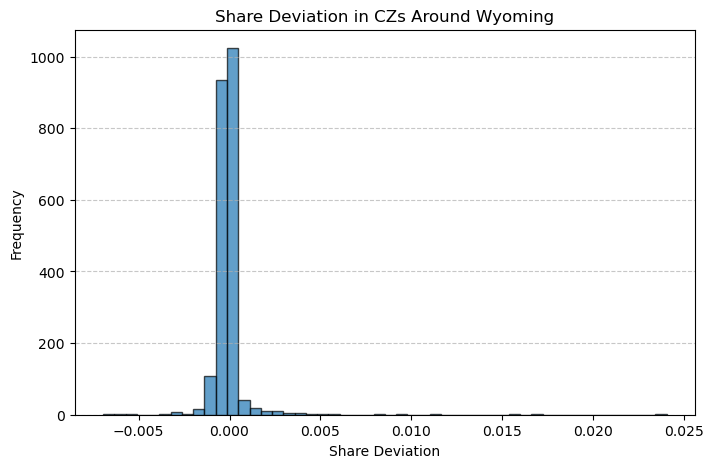

In [226]:
plt.figure(figsize=(8, 5))
plt.hist(df_around_wy['Share_Deviation'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Share Deviation")
plt.ylabel("Frequency")
plt.title("Share Deviation in CZs Around Wyoming")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

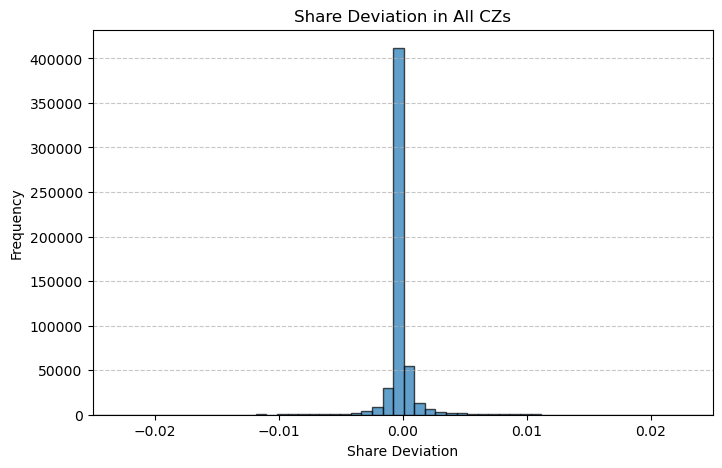

In [227]:
plt.figure(figsize=(8, 5))
plt.hist(df_cz['Share_Deviation'], bins=1000, edgecolor='black', alpha=0.7)
plt.xlabel("Share Deviation")
plt.ylabel("Frequency")
plt.title("Share Deviation in All CZs")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set x-axis limit
plt.xlim(-0.025, 0.025)

plt.show()

In [228]:
df_around_wy['RCA'] = df_around_wy['Employment_Share'] / df_around_wy['Expected_Share']

# Apply transformation to normalize RCA
df_around_wy['Share_Deviation_Normalized'] = (df_around_wy['RCA'] + 1) / (df_around_wy['RCA'] - 1)

In [229]:
df_around_wy.sort_values(by="Share_Deviation_Normalized", ascending=False).head(10)

,Area Name,Industry Name,Area,Industry,Year,Jobs,CZ20,Jobs_county,Jobs_CZ,Total_Jobs_CZ,...,Beta2_tj,Expected_Jobs,Jobs_Deviation,Intercept_sj,Beta1_sj,Beta2_sj,Expected_Share,Share_Deviation,RCA,Share_Deviation_Normalized
774,"Bannock County, ID",All Other Miscellaneous Textile Product Mills,16005,314999,2024,10.537461,131.0,10.537461,44.284027,158324.310709,...,-0.012648,40.863884,3.420143,-15.025999,1.233863,-0.055321,0.000279,4.332831e-07,1.001551,1290.093513
5988,"Broadwater County, MT","Agents and Managers for Artists, Athletes, Ent...",30007,711410,2024,0.000000,326.0,0.000000,2.614748,119739.967157,...,0.204952,2.053084,0.561663,-2.304888,-1.880025,0.099084,0.000022,1.900881e-07,1.008781,228.755441
1947,"Larimer County, CO",Conveyor and Conveying Equipment Manufacturing,8069,333922,2024,108.343981,84.0,108.343981,108.343981,303165.691624,...,-0.050357,105.214880,3.129101,-31.973941,4.571058,-0.211344,0.000353,4.105218e-06,1.011621,173.107928
2129,"Franklin County, ID","Industrial Truck, Tractor, Trailer, and Stacke...",16041,333924,2024,0.000000,139.0,0.000000,76.244594,92918.977464,...,-0.076597,51.067646,25.176947,-68.701944,10.763756,-0.470353,0.000808,1.291566e-05,1.015992,126.062640
101,"Bannock County, ID","Crop Harvesting, Primarily by Machine",16005,115113,2024,8.142017,131.0,8.142017,18.448062,158324.310709,...,-0.045352,20.156388,-1.708326,-7.752106,0.194257,-0.025574,0.000113,3.976614e-06,1.035334,57.602976
1921,"Larimer County, CO",All Other Miscellaneous Fabricated Metal Produ...,8069,332999,2024,12.714113,84.0,12.714113,284.140546,303165.691624,...,-0.030583,217.017528,67.123019,-29.670370,3.850685,-0.162848,0.000902,3.553865e-05,1.039413,51.745106
1973,"Larimer County, CO",Instruments and Related Products Manufacturing...,8069,334513,2024,111.197728,84.0,111.197728,112.761157,303165.691624,...,-0.046770,108.022371,4.738786,-15.683523,1.133593,-0.041182,0.000358,1.440322e-05,1.040284,50.647569
4494,"Larimer County, CO",Industrial Design Services,8069,541420,2024,4.401098,84.0,4.401098,20.067765,303165.691624,...,-0.092458,23.250558,-3.182794,-6.845662,-0.836849,0.048603,0.000063,2.736688e-06,1.043126,47.375299
2011,"Bannock County, ID",All Other Miscellaneous Fabricated Metal Produ...,16005,332999,2024,5.439722,131.0,5.439722,165.071746,158324.310709,...,-0.030583,127.185542,37.886204,-29.670370,3.850685,-0.162848,0.000997,4.572301e-05,1.045865,44.605827
2131,"Franklin County, ID",Welding and Soldering Equipment Manufacturing,16041,333992,2024,0.000000,139.0,0.000000,9.237517,92918.977464,...,-0.060124,8.211796,1.025721,-9.247250,0.000239,-0.000134,0.000095,4.454146e-06,1.046905,43.639202


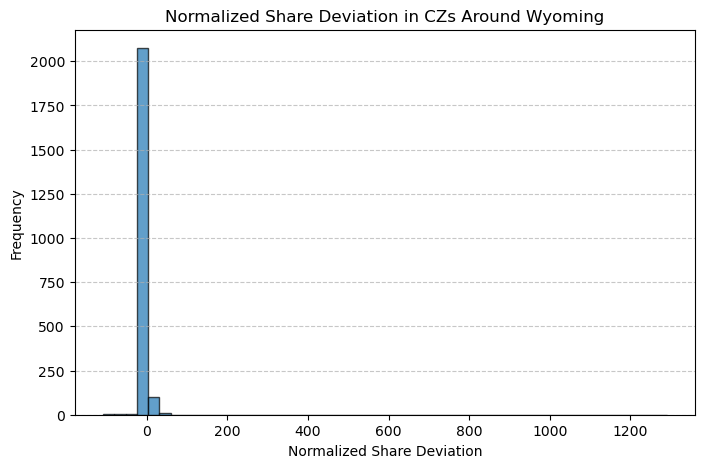

In [230]:
plt.figure(figsize=(8, 5))
plt.hist(df_around_wy['Share_Deviation_Normalized'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Normalized Share Deviation")
plt.ylabel("Frequency")
plt.title("Normalized Share Deviation in CZs Around Wyoming")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [231]:
import plotly.express as px

# Define color scale
def get_color(value):
    if value > 0.05:  # Positive values
        return "green"
    elif value < -0.05:  # Negative values
        return "red"
    else:  # Close to zero
        return "gray"

# Apply color function
df_around_wy["Color"] = df_around_wy["Share_Deviation_Normalized"].apply(get_color)

# Create tree maps for each commuting zone (CZ20)
for cz in df_around_wy["CZ20"].unique():
    df_czs = df_around_wy[df_around_wy["CZ20"] == cz]

    # Create Plotly Treemap
    fig = px.treemap(
        df_czs,
        path=["CZ20", "Industry Name"],  # Hierarchy: CZ → Industry
        values="Share_Deviation_Normalized",
        color="Color",  # Use manually assigned colors
        title=f"Industry Share Deviation (Normalized) in CZ {cz}",
        color_discrete_map={"green": "green", "red": "red", "gray": "gray"}
    )
    
    # Show the plot
    fig.show()

In [232]:
# Filter the dataframe for CZ20 values of 84 or 131
#df_84131 = df_around_wy[df_around_wy["CZ20"].isin([84, 131])]

#display(df_84131)

In [233]:

# Get unique commuting zones
unique_czs = df_around_wy["CZ20"].unique()

# Generate a separate treemap for each CZ
for cz in unique_czs:
    df_czs = df_around_wy[df_around_wy["CZ20"] == cz]

    # Get the most common or first Area Name for the CZ
    area_name = df_czs["Area Name"].mode()[0] if not df_czs["Area Name"].isna().all() else "Unknown Location"

    # Create the treemap
    fig = px.treemap(
        df_czs,
        path=["Industry Name"],  # Only industries within each CZ
        values="Share_Deviation_Normalized",  # Size varies within each CZ
        color="Share_Deviation_Normalized",  # Color represents deviation
        color_continuous_scale=[(0, "white"), (0.5, "lightgreen"), (1, "green")],  
        title=f"Treemap for {area_name} (Commuting Zone {cz})"
    )

    fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
    fig.show()


In [234]:
'''
import plotly.io as pio

# Generate a separate treemap for each CZ
for cz in unique_czs:
    df_czs = df_around_wy[df_around_wy["CZ20"] == cz]
    area_name = df_czs["Area Name"].mode()[0] if not df_czs["Area Name"].isna().all() else "Unknown Location"

    # Create the treemap
    fig = px.treemap(
        df_czs,
        path=["Industry Name"],
        values="Share_Deviation_Normalized",
        color="Share_Deviation_Normalized",
        color_continuous_scale=[(0, "white"), (0.5, "lightgreen"), (1, "green")],  
        title=f"Treemap for {area_name} (Commuting Zone {cz})"
    )

    fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))

    # Save and open in browser
    pio.write_html(fig, file=f"treemap_{cz}.html", auto_open=True)
'''

'\nimport plotly.io as pio\n\n# Generate a separate treemap for each CZ\nfor cz in unique_czs:\n    df_czs = df_around_wy[df_around_wy["CZ20"] == cz]\n    area_name = df_czs["Area Name"].mode()[0] if not df_czs["Area Name"].isna().all() else "Unknown Location"\n\n    # Create the treemap\n    fig = px.treemap(\n        df_czs,\n        path=["Industry Name"],\n        values="Share_Deviation_Normalized",\n        color="Share_Deviation_Normalized",\n        color_continuous_scale=[(0, "white"), (0.5, "lightgreen"), (1, "green")],  \n        title=f"Treemap for {area_name} (Commuting Zone {cz})"\n    )\n\n    fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))\n\n    # Save and open in browser\n    pio.write_html(fig, file=f"treemap_{cz}.html", auto_open=True)\n'

In [235]:
import dash
from dash import dcc, html, dash_table
from dash.dependencies import Input, Output
import pandas as pd
import plotly.express as px

In [279]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
from dash import dcc, html, Input, Output, dash_table, Dash
import plotly.express as px
import webbrowser

app = Dash(__name__)

# Unique CZs for dropdown selection
unique_czs = df_around_wy["CZ20"].unique()

# App Layout
app.layout = html.Div([
    html.H1("Interactive Treemap of CZ Industries", style={'textAlign': 'center'}),

    # Dropdown to select a CZ
    html.Label("Select a Commuting Zone:"),
    dcc.Dropdown(
        id="cz-dropdown",
        options=[{"label": f"CZ {cz}", "value": cz} for cz in unique_czs],
        value=unique_czs[0],  # Default selection
        clearable=False
    ),

    # Treemap visualization
    dcc.Graph(id="treemap"),

    # Clicked row data output
    html.H3("Industry Details:", style={'textAlign': 'center'}),
    dash_table.DataTable(
        id="industry-details",
        columns=[{"name": col, "id": col} for col in df_around_wy.columns],
        style_table={'overflowX': 'auto', 'margin': 'auto'},
        style_header={'backgroundColor': 'lightgrey', 'fontWeight': 'bold'},
        style_data={'whiteSpace': 'normal', 'height': 'auto'}
    ),
    
    # Placeholder for regression plot
    dcc.Graph(id="regression-plot")
])

# Callbacks for Interactivity
@app.callback(
    Output("treemap", "figure"),
    Input("cz-dropdown", "value")
)
def update_treemap(selected_cz):
    df_czs = df_around_wy[df_around_wy["CZ20"] == selected_cz]
    area_name = df_czs["Area Name"].mode()[0] if not df_czs["Area Name"].isna().all() else "Unknown Location"

    min_val = df_czs["Share_Deviation_Normalized"].min()
    max_val = df_czs["Share_Deviation_Normalized"].max()

    # Ensure we have a valid range
    if min_val == max_val:  
        color_scale = [(0, "white")]
    else:
        color_scale = []
        if min_val < 0:
            color_scale.append((0, "red"))  # Red for negative values
        color_scale.append((0.5, "white"))  # White fixed at zero
        color_scale.append((1, "darkgreen"))  # Dark green for max value

    fig = px.treemap(
        df_czs,
        path=["Industry Name"],
        values="Share_Deviation_Normalized",
        color="Share_Deviation_Normalized",
        color_continuous_scale=color_scale,
        color_continuous_midpoint=0,  # Ensures white is centered at 0
        title=f"Treemap for {area_name} (Commuting Zone {selected_cz})",
        labels={"Industry Name": "Industry"}
    )

    return fig


@app.callback(
    [Output("industry-details", "data"), Output("regression-plot", "figure")],
    [Input("treemap", "clickData"), Input("cz-dropdown", "value")]
)
def display_clicked_data(clickData, selected_cz):
    if clickData:
        industry_name = clickData["points"][0]["label"]
        selected_row = df_around_wy[df_around_wy["Industry Name"] == industry_name].iloc[0]
        fig = run_ppml_sj(df_cz, selected_row["Industry"], selected_cz)
        return [selected_row.to_dict()], fig
    return [], px.scatter(title="Select an industry for regression analysis")

def run_ppml_sj(df, naics_code, selected_cz):
    """
    Runs a Pseudo-Poisson Maximum Likelihood (PPML) regression for a specific industry
    identified by its 6-digit NAICS code across all commuting zones (CZ20) 
    and generates a single plot.
    """
    
    naics_code = str(naics_code)
    if naics_code not in df["Industry"].astype(str).values:
        print(f"No data available for NAICS code {naics_code}.")
        return px.scatter(title="No data available")

    industry_name = df[df["Industry"].astype(str) == naics_code]["Industry Name"].iloc[0]
    df_industry = df[df["Industry"].astype(str) == naics_code].copy()
    df_industry = df_industry.replace([np.inf, -np.inf], np.nan).dropna()

    formula = "Employment_Share ~ Log_Total_Jobs_CZ + Log_Total_Jobs_CZ_Squared"
    model = smf.glm(formula=formula, data=df_industry, family=sm.families.Poisson()).fit()
    print(model.summary())

    df_industry['Predicted_Share'] = model.predict(df_industry)
    sorted_df = df_industry.sort_values('Log_Total_Jobs_CZ')

    fig = px.scatter(df_industry, x='Log_Total_Jobs_CZ', y='Employment_Share', opacity=0.5, labels={'Log_Total_Jobs_CZ': "Log Total Jobs in CZ", 'Employment_Share': "Employment Share"})
    fig.add_scatter(x=sorted_df['Log_Total_Jobs_CZ'], y=sorted_df['Predicted_Share'], mode='lines', name='PPML Fit', line=dict(color='red'))
    
    selected_cz_data = df_industry[df_industry['CZ20'] == selected_cz]
    if not selected_cz_data.empty:
        fig.add_scatter(x=selected_cz_data['Log_Total_Jobs_CZ'], y=selected_cz_data['Employment_Share'], mode='markers', name=f'Selected CZ {selected_cz}', marker=dict(color='blue', size=10))
    
    fig.update_layout(title=f"PPML Regression for {industry_name} (NAICS {naics_code})", xaxis_title="Log Number of Total Jobs in Commuting Zone", yaxis_title=f"Share of Jobs in {industry_name} in Commuting Zone", legend_title="Legend")
    
    return fig

# Run the Dash App
if __name__ == "__main__":
    webbrowser.open_new("http://127.0.0.1:8050/")
    app.run_server(debug=True, dev_tools_ui=True, dev_tools_hot_reload=True, threaded=True, use_reloader=False)



                 Generalized Linear Model Regression Results                  
Dep. Variable:       Employment_Share   No. Observations:                  583
Model:                            GLM   Df Residuals:                      580
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:              -0.050998
Date:                Wed, 12 Mar 2025   Deviance:                     0.015002
Time:                        18:51:42   Pearson chi2:                   0.0697
No. Iterations:                     5   Pseudo R-squ. (CS):          1.116e-05
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             